# Datos Censales a Nivel Individual

Por **Eduardo Graells-Garrido** y Daniela Opitz. <dopitz@udd.cl>.
Actualizado: **22 de abril de 2024**.

Los microdatos del [Censo 2017](http://www.censo2017.cl/) se pueden obtener visitando las oficinas del Instituto Nacional de Estadísticas y pedirlos en un DVD. Ya incluí los archivos del Censo que usaremos la carpeta `censo2017/`, no es necesario que vayas a pedir el DVD.

A diferencia de otros notebooks en este repositorio, los microdatos son demasiado grandes para procesarlos directamente con el módulo `pandas`. Por _demasiado grandes_ me refiero a que superan el límite de almacenamiento impuesto por algunas plataformas de manejo de código como [GitHub](https://github.com/). Por ejemplo, el archivo `Microdatro_Censo2017-Personas.csv` pesa 2.2 Gigabytes. Quizás en un computador más o menos moderno se puedan cargar estos datos en memoria RAM, pero es probable que no se pueda, a fin de cuentas, también usamos programas grandes, navegadores, escuchamos música, etc.

Por eso en este notebook utilizaremos otra herramienta que permite analizar datos que incluso no caben en la memoria. Y, al mismo tiempo, permite hacer procesamiento en paralelo, aprovechando la cantidad de núcleos que tengan nuestras máquinas. Esta herramienta se llama [Dask](https://dask.pydata.org/en/latest/) y se construye sobre `pandas`, así que si sabemos algo de `pandas` también sabemos algo de `dask` :)

Como preguntas para analizar tendremos las siguientes:

  * ¿De dónde provienen les inmigrantes?
  * ¿Existen diferencias entre los tiempos de llegada al país dependiendo del origen?
  * ¿Existen diferencias en los destinos dentro de Chile donde residen, dependiendo del origen?

## Preámbulo

Y descargar los datos si es que estás usando Google Colab

In [1]:
try:
    import google.colab
    !curl -L -o censo2017.zip 'https://www.dropbox.com/scl/fi/gx94xhhvwm5ncilwyt0yc/censo2017.zip?rlkey=zufb4zjrbx614gep3pra5qix5&st=pl1s7cde&dl=0'
    !unzip -o censo2017.zip
except:
    pass

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    192      0 --:--:--  0:00:01 --:--:--   192
100   491    0   491    0     0    262      0 --:--:--  0:00:01 --:--:--     0
100  295M  100  295M    0     0  32.3M      0  0:00:09  0:00:09 --:--:-- 18.0M
Archive:  censo2017.zip
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Categorias.csv  
 extracting: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Areas.csv  
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Regiones.csv  
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Comunas.csv  
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Urbano.csv  
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Geografia.csv  
  inflat

In [2]:
try:
    import google.colab
    !curl -L -o Fira_Sans_Extra_Condensed.zip 'https://www.dropbox.com/s/82nuhtpybfpjeq9/Fira_Sans_Extra_Condensed.zip?dl=1'
    !unzip -o Fira_Sans_Extra_Condensed.zip
    import matplotlib as mpl
    mpl.font_manager.fontManager.addfont('Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-Regular.ttf')
    #mpl.rc('font', family='Fira Sans Extra Condensed')
except:
    pass

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    74    0    74    0     0     84      0 --:--:-- --:--:-- --:--:--    84
100   320  100   320    0     0    242      0  0:00:01  0:00:01 --:--:--   242
100 3733k  100 3733k    0     0  1132k      0  0:00:03  0:00:03 --:--:-- 5100k
Archive:  Fira_Sans_Extra_Condensed.zip
  inflating: __MACOSX/._Fira_Sans_Extra_Condensed  
  inflating: Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-MediumItalic.ttf  
  inflating: __MACOSX/Fira_Sans_Extra_Condensed/._FiraSansExtraCondensed-MediumItalic.ttf  
  inflating: Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-Italic.ttf  
  inflating: __MACOSX/Fira_Sans_Extra_Condensed/._FiraSansExtraCondensed-Italic.ttf  
  inflating: Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-BlackItalic.ttf  
  inflating: __MACOSX/Fira_Sans_Extra_Condensed/._FiraSansExtraCondensed-BlackItalic.ttf  
  inflat

Carga y configuración de bibliotecas para este notebook.

In [3]:
import pandas as pd
import dask.dataframe as dd

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='ticks', font='sans-serif', context='notebook', palette='viridis')
%config InlineBackend.figure_format='retina'

# esto configura la calidad de la imagen. dependerá de tu resolución. el valor por omisión es 80
plt.rcParams["figure.dpi"] = 96
# esto depende de las fuentes que tengas instaladas en tu sistema.
plt.rcParams["font.family"] = "Fira Sans Extra Condensed"

In [5]:
pd.set_option('display.max_columns', None)

## Carguemos los Datos

In [6]:
census = dd.read_csv('censo2017/Microdato_Censo2017-Personas.csv', sep=';')
census.head()

,REGION,PROVINCIA,COMUNA,DC,AREA,ZC_LOC,ID_ZONA_LOC,NVIV,NHOGAR,PERSONAN,P07,P08,P09,P10,P10COMUNA,P10PAIS,P11,P11COMUNA,P11PAIS,P12,P12COMUNA,P12PAIS,P12A_LLEGADA,P12A_TRAMO,P13,P14,P15,P15A,P16,P16A,P16A_OTRO,P17,P18,P19,P20,P21M,P21A,P10PAIS_GRUPO,P11PAIS_GRUPO,P12PAIS_GRUPO,ESCOLARIDAD,P16A_GRUPO
0,15,152,15202,1,2,6,13225,1,1,1,1,1,73,1,98,998,3,15101,998,1,98,998,9998,98,2,4,6,2,1,2,98,7,98,98,98,98,9998,998,998,998,4,2
1,15,152,15202,1,2,6,13225,3,1,1,1,1,78,1,98,998,2,98,998,1,98,998,9998,98,3,98,98,98,1,2,98,7,98,98,98,98,9998,998,998,998,0,2
2,15,152,15202,1,2,6,13225,3,1,2,2,2,78,1,98,998,2,98,998,1,98,998,9998,98,3,98,98,98,1,2,98,7,98,1,1,3,1965,998,998,998,0,2
3,15,152,15202,1,2,6,13225,3,1,3,5,2,52,1,98,998,2,98,998,1,98,998,9998,98,1,2,5,2,1,2,98,7,98,2,1,4,1995,998,998,998,2,2
4,15,152,15202,1,2,6,13225,3,1,4,11,1,44,1,98,998,2,98,998,1,98,998,9998,98,1,3,5,2,1,2,98,1,Z,98,98,98,9998,998,998,998,3,2


In [7]:
len(census)

17574003

## ¿De dónde provienen les inmigrantes?

In [8]:
migrant_origins = census.groupby('P12PAIS_GRUPO').size().compute()

Noten la diferencia con `pandas`: hay un método `compute()` que le dice a `dask` que ejecute el cálculo. A diferencia de `pandas`, en esta biblioteca _no_ se ejecutan las tareas de manera inmediata. Esto le permite a `dask` agrupar tareas y planear una estrategia de cálculo (recordemos que los datos no están en la memoria RAM, y que además utilizará procesamiento en paralelo).

In [9]:
migrant_origins

P12PAIS_GRUPO
2          1722
5         27040
9          2250
13        11269
21        16191
29        19781
32        73867
68        77503
142       21654
150       50612
170      108001
218       28612
332       64567
604      192082
862       85461
997        4073
998    16471743
999      317575
dtype: int64

In [10]:
migrant_origins=migrant_origins.to_frame().reset_index()
migrant_origins

,P12PAIS_GRUPO,0
0,2,1722
1,5,27040
2,9,2250
3,13,11269
4,21,16191
5,29,19781
6,32,73867
7,68,77503
8,142,21654
9,150,50612


In [11]:
migrant_origins.rename(columns={0:'Nº_MIGRANTES','P12PAIS_GRUPO':'CODIGO_PAIS' }, inplace=True)
migrant_origins

,CODIGO_PAIS,Nº_MIGRANTES
0,2,1722
1,5,27040
2,9,2250
3,13,11269
4,21,16191
5,29,19781
6,32,73867
7,68,77503
8,142,21654
9,150,50612


Vemos, por ejemplo, que la opción 998 ("No Aplica") es 16471743. Es decir, esa es la cantidad de personas chilenas. Pero, ¿cómo identificar los otros códigos? Debemos traducirlos o decodificarlos con un archivo auxiliar que viene en el dataset. Como es un archivo pequeño lo podemos cargar con `pandas` sin preocupación:

In [12]:
country_codes = pd.read_csv('censo2017/Censo2017_Etiquetas_Persona/Etiquetas_Persona_PAIS_GRUPO.csv', sep=';', index_col='valor')
country_codes

,glosa
valor,
2,África
5,Sudamérica
9,Oceanía
10,Antártida
13,Centroamérica
21,Norteamérica
29,Caribe
32,Argentina
68,Bolivia (Estado Plurinacional de)


Lo que necesitamos ahora es _unir_ ambas fuentes de datos a través del índice en común que tienen: el código de la respuesta a la pregunta `P12`. Aprovecharemos de eliminar las opciones que no nos interesan: 997, 998 y 999.

In [13]:
country_codes.reset_index(inplace=True)
country_codes

,valor,glosa
0,2,África
1,5,Sudamérica
2,9,Oceanía
3,10,Antártida
4,13,Centroamérica
5,21,Norteamérica
6,29,Caribe
7,32,Argentina
8,68,Bolivia (Estado Plurinacional de)
9,142,Asia


In [14]:
country_codes.rename(columns={'valor': 'CODIGO_PAIS', 'glosa':'CONTINENTE'}, inplace=True)
country_codes

,CODIGO_PAIS,CONTINENTE
0,2,África
1,5,Sudamérica
2,9,Oceanía
3,10,Antártida
4,13,Centroamérica
5,21,Norteamérica
6,29,Caribe
7,32,Argentina
8,68,Bolivia (Estado Plurinacional de)
9,142,Asia


In [15]:
migrant_origins = migrant_origins.merge(country_codes, on='CODIGO_PAIS')
migrant_origins

,CODIGO_PAIS,Nº_MIGRANTES,CONTINENTE
0,2,1722,África
1,5,27040,Sudamérica
2,9,2250,Oceanía
3,13,11269,Centroamérica
4,21,16191,Norteamérica
5,29,19781,Caribe
6,32,73867,Argentina
7,68,77503,Bolivia (Estado Plurinacional de)
8,142,21654,Asia
9,150,50612,Europa


In [16]:
migrant_origins = migrant_origins[(migrant_origins['CODIGO_PAIS'] != 997) & (migrant_origins['CODIGO_PAIS'] != 998) &  (migrant_origins['CODIGO_PAIS'] != 999)]
migrant_origins

,CODIGO_PAIS,Nº_MIGRANTES,CONTINENTE
0,2,1722,África
1,5,27040,Sudamérica
2,9,2250,Oceanía
3,13,11269,Centroamérica
4,21,16191,Norteamérica
5,29,19781,Caribe
6,32,73867,Argentina
7,68,77503,Bolivia (Estado Plurinacional de)
8,142,21654,Asia
9,150,50612,Europa


In [17]:
paises={'Venezuela (República Bolivariana de)':'Venezuela', 'Bolivia (Estado Plurinacional de)':'Bolivia'}
migrant_origins['CONTINENTE']=migrant_origins['CONTINENTE'].replace(paises)
migrant_origins

<ipython-input-17-d78ef2c159bb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  migrant_origins['CONTINENTE']=migrant_origins['CONTINENTE'].replace(paises)


,CODIGO_PAIS,Nº_MIGRANTES,CONTINENTE
0,2,1722,África
1,5,27040,Sudamérica
2,9,2250,Oceanía
3,13,11269,Centroamérica
4,21,16191,Norteamérica
5,29,19781,Caribe
6,32,73867,Argentina
7,68,77503,Bolivia
8,142,21654,Asia
9,150,50612,Europa


In [18]:
!mkdir -p censo2017_figuras

<ipython-input-19-3b24206de8ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  migrant_origins.sort_values('Nº_MIGRANTES', inplace=True)


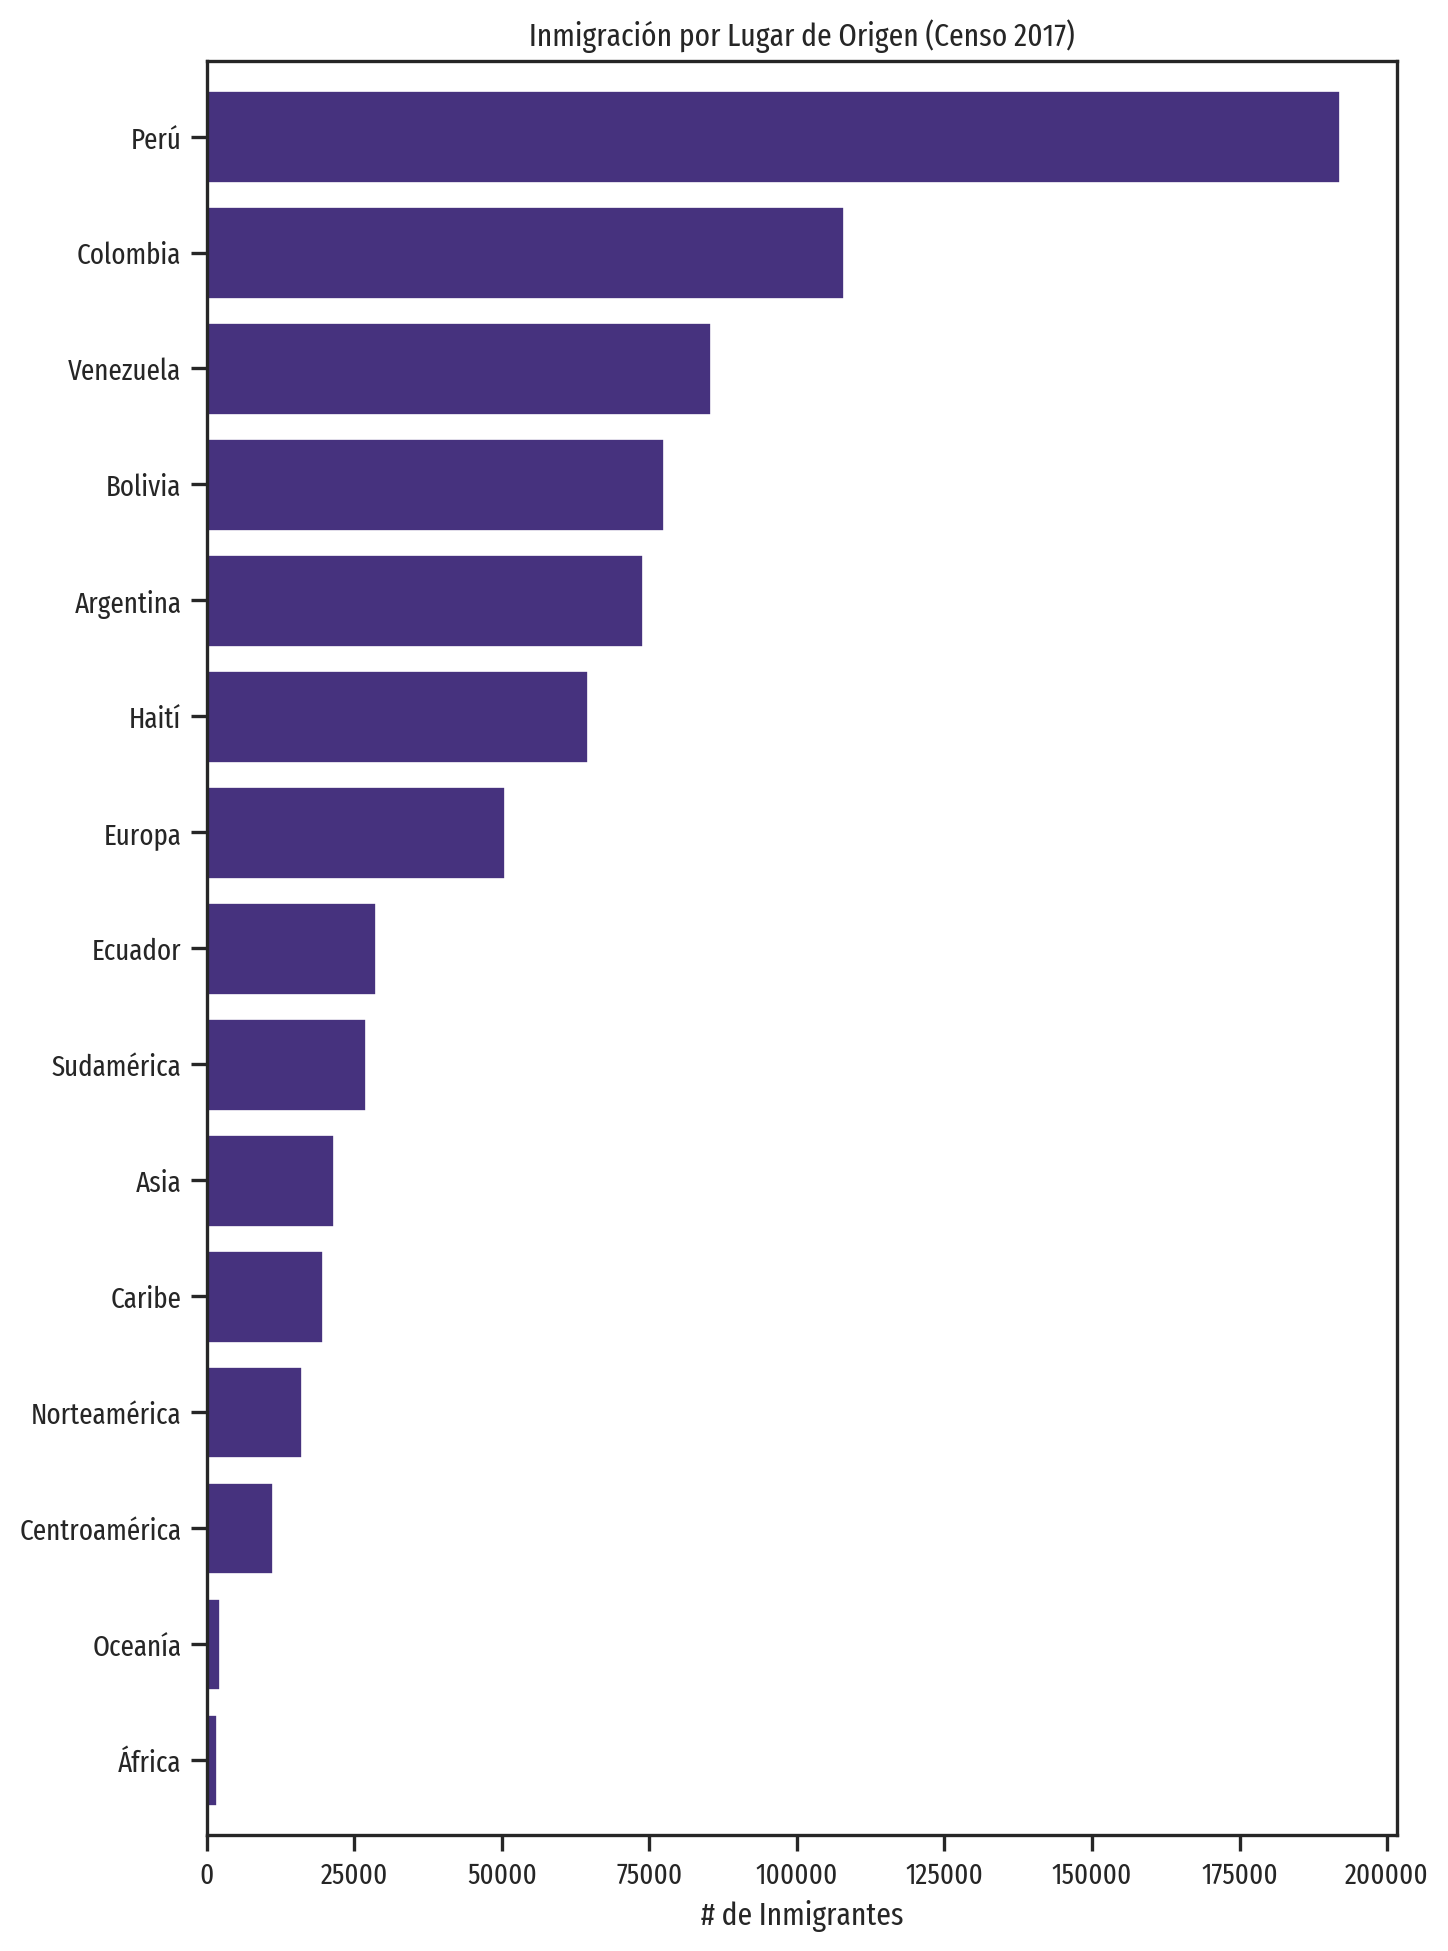

In [19]:
# Crear el gráfico de barras horizontal directamente con matplotlib
migrant_origins.sort_values('Nº_MIGRANTES', inplace=True)
migrant_origins.set_index('CONTINENTE', inplace=True)

fig, ax = plt.subplots(figsize=(8, 12))
ax=migrant_origins['Nº_MIGRANTES'].plot(kind='barh', width=0.8, ax=ax)

# Estilizar el gráfico
ax.set_xlabel('# de Inmigrantes')
ax.set_ylabel('')
ax.set_title('Inmigración por Lugar de Origen (Censo 2017)')

# Guardar la figura
plt.savefig('censo2017_figuras/migrant_count_per_country.png', dpi=150, bbox_inches='tight')
plt.show()

## ¿Existen diferencias entre los tiempos de llegada al país dependiendo del origen?

Realizaremos un procedimiento similar, pero esta vez agruparemos por dos variables: agregamos el año de llegada al país.

In [20]:
migrant_year_counts = census.groupby(['P12PAIS_GRUPO', 'P12A_LLEGADA']).size().compute()

In [21]:
migrant_year_counts.sample(10)

P12PAIS_GRUPO  P12A_LLEGADA
32             1994            1052
142            1976              26
13             2011             438
218            1996             207
150            1975             139
21             1953               8
170            1975              12
32             1958             107
604            2013            9641
142            2004             307
dtype: int64

In [22]:
migrant_year_counts=migrant_year_counts.to_frame().reset_index().rename(columns={0: 'Nº_MIGRANTES', 'P12PAIS_GRUPO': 'CODIGO_PAIS','P12A_LLEGADA': 'AÑO'})
migrant_year_counts

,CODIGO_PAIS,AÑO,Nº_MIGRANTES
0,2,1950,14
1,2,1956,3
2,2,1958,2
3,2,1990,12
4,2,1991,24
...,...,...,...
1044,997,1952,4
1045,2,1966,1
1046,862,1953,2
1047,332,1982,1


In [23]:
year_counts = migrant_year_counts.merge(country_codes, on='CODIGO_PAIS')
year_counts.head()

,CODIGO_PAIS,AÑO,Nº_MIGRANTES,CONTINENTE
0,2,1950,14,África
1,2,1956,3,África
2,2,1958,2,África
3,2,1990,12,África
4,2,1991,24,África


In [24]:
year_counts['CONTINENTE']=year_counts['CONTINENTE'].replace(paises)

In [25]:
year_counts=year_counts[year_counts['CONTINENTE']!='País no declarado']

Con esta tabla quiséramos construir series temporales que nos ayuden a ver los patrones de llegada en la inmigración (notemos que hay valores inválidos, como año 9999):

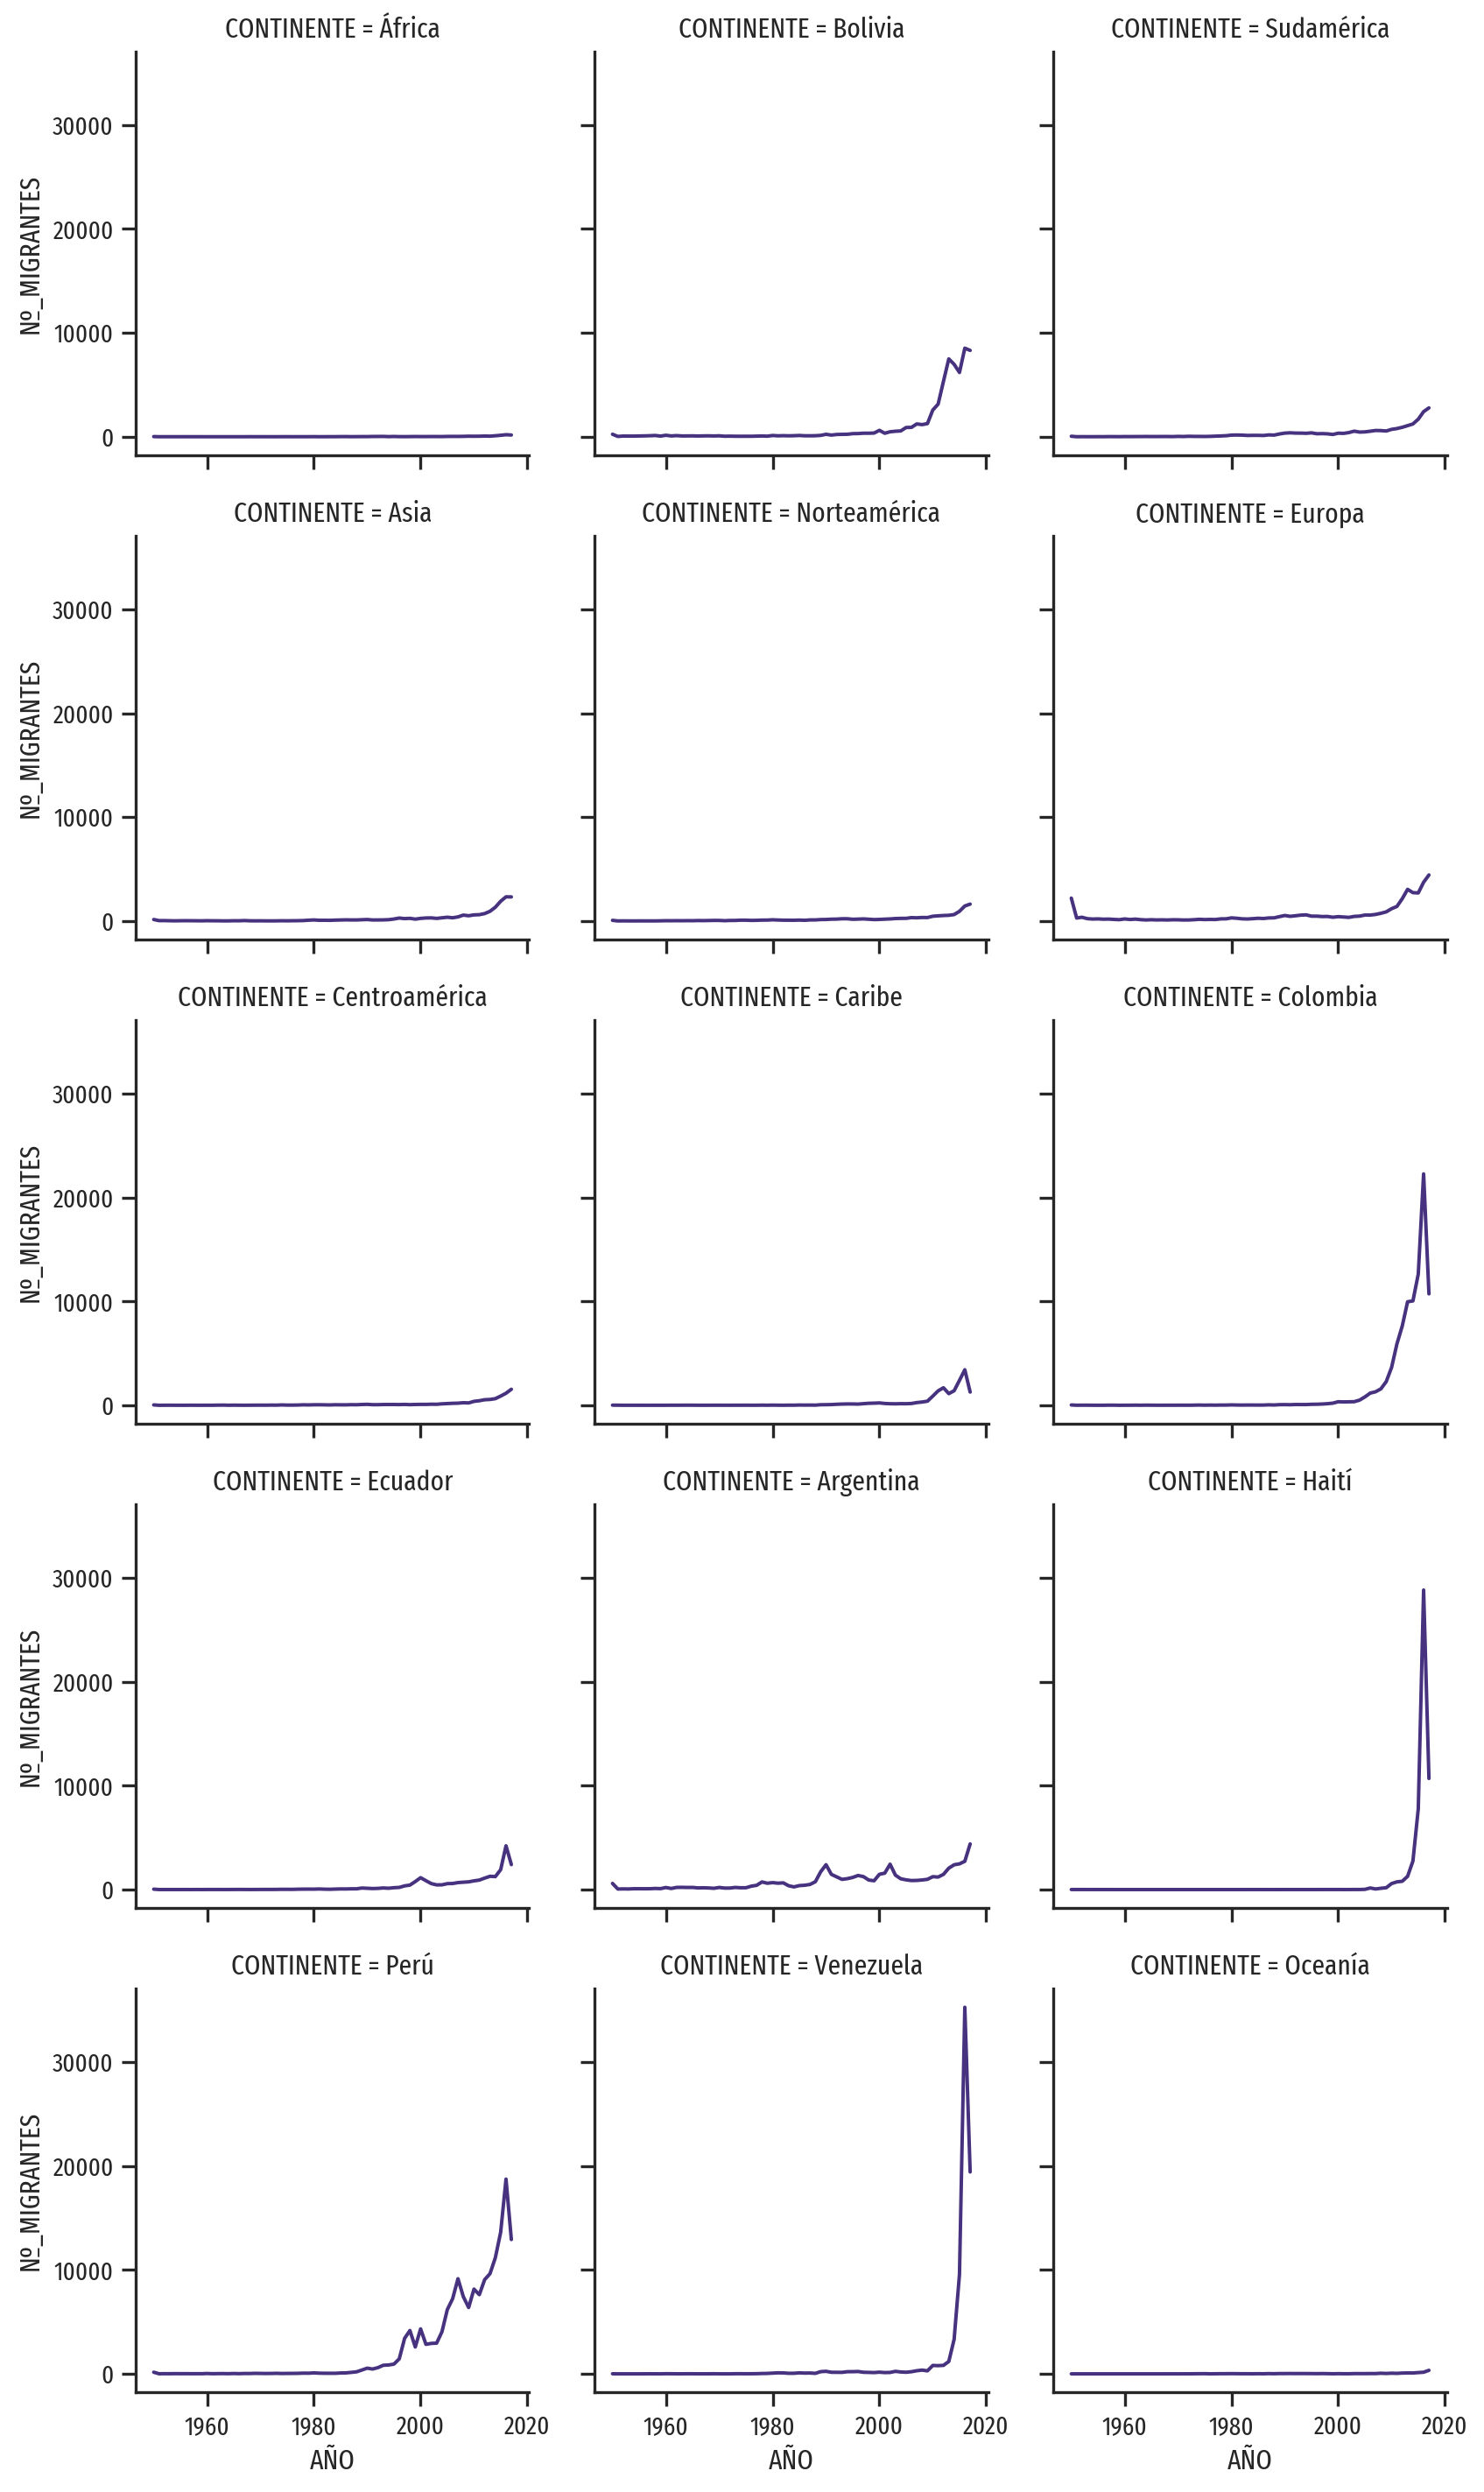

In [26]:
# Creación de un FacetGrid para visualizar los datos de migración por continente hasta el año 2017
# Filtra los datos para años hasta 2017, los ordena por año, y crea un grid con una columna por continente o país,
# con un máximo de tres columnas por fila.
g = sns.FacetGrid(data=year_counts[year_counts.AÑO <= 2017].sort_values('AÑO'), col='CONTINENTE', col_wrap=3)

# La función g.map() en Seaborn es utilizada para aplicar una función de visualización a cada subplot dentro de un objeto FacetGrid.
# En esencia, te permite mapear una función de gráficos (como plt.plot, plt.scatter, entre otros) a través de las diferentes facetas del grid que has definido.
# Facilita la creación de múltiples gráficos en una sola figura de manera eficiente y con un código reducido.
g.map(plt.plot, 'AÑO', 'Nº_MIGRANTES')

# Guarda la figura generada en el disco con alta resolución (150 dpi) y ajustando los bordes de la figura
# para que no haya espacios innecesarios alrededor del contenido.
plt.savefig('censo2017_figuras/migrant_series.png', dpi=150, bbox_inches='tight')


¡Qué interesante! Podemos ver patrones _por origen_, sin embargo, cuesta tener una visión global y comparar entre orígenes, puesto que la cantidad por cada uno es distinta. Para eso podemos construir una matriz que luego normalizaremos por filas, de modo que el año que cada origen tenga su esté asociado al numero total de inmigrantes de ese país:

In [27]:
year_counts

,CODIGO_PAIS,AÑO,Nº_MIGRANTES,CONTINENTE
0,2,1950,14,África
1,2,1956,3,África
2,2,1958,2,África
3,2,1990,12,África
4,2,1991,24,África
...,...,...,...,...
975,862,1955,1,Venezuela
976,862,1971,2,Venezuela
977,862,1953,2,Venezuela
1047,998,9998,16471743,No aplica


In [28]:
year_counts=year_counts[(year_counts['AÑO']!=9998) & (year_counts['AÑO']!=9999)]
year_counts

,CODIGO_PAIS,AÑO,Nº_MIGRANTES,CONTINENTE
0,2,1950,14,África
1,2,1956,3,África
2,2,1958,2,África
3,2,1990,12,África
4,2,1991,24,África
...,...,...,...,...
973,862,1969,11,Venezuela
974,862,1970,3,Venezuela
975,862,1955,1,Venezuela
976,862,1971,2,Venezuela


In [29]:
year_counts2=year_counts.pivot_table(index='CONTINENTE', columns='AÑO', values='Nº_MIGRANTES').fillna(0)

In [30]:
year_counts2

AÑO,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
CONTINENTE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,593.0,53.0,64.0,57.0,83.0,81.0,79.0,82.0,107.0,89.0,200.0,104.0,208.0,214.0,202.0,206.0,159.0,172.0,155.0,123.0,203.0,143.0,146.0,205.0,173.0,176.0,328.0,409.0,734.0,610.0,669.0,615.0,646.0,366.0,258.0,383.0,415.0,494.0,756.0,1712.0,2395.0,1464.0,1221.0,982.0,1052.0,1167.0,1356.0,1248.0,919.0,847.0,1471.0,1580.0,2443.0,1388.0,1039.0,935.0,869.0,880.0,922.0,987.0,1241.0,1205.0,1464.0,2062.0,2387.0,2475.0,2722.0,4393.0
Asia,145.0,37.0,39.0,26.0,18.0,26.0,30.0,27.0,22.0,18.0,31.0,22.0,20.0,12.0,13.0,25.0,22.0,43.0,21.0,16.0,18.0,13.0,12.0,14.0,24.0,19.0,26.0,31.0,43.0,76.0,102.0,69.0,71.0,64.0,85.0,98.0,111.0,103.0,102.0,123.0,143.0,100.0,102.0,108.0,128.0,192.0,285.0,230.0,258.0,180.0,254.0,291.0,300.0,252.0,307.0,364.0,310.0,395.0,569.0,506.0,588.0,608.0,715.0,935.0,1326.0,1903.0,2328.0,2319.0
Bolivia,238.0,29.0,64.0,60.0,61.0,71.0,82.0,97.0,119.0,61.0,140.0,76.0,107.0,74.0,77.0,81.0,69.0,80.0,85.0,73.0,87.0,47.0,55.0,46.0,43.0,45.0,44.0,57.0,71.0,52.0,119.0,87.0,102.0,88.0,99.0,121.0,91.0,89.0,97.0,129.0,235.0,157.0,217.0,228.0,236.0,297.0,303.0,338.0,338.0,353.0,616.0,335.0,476.0,528.0,557.0,889.0,899.0,1231.0,1165.0,1264.0,2568.0,3138.0,5330.0,7491.0,6968.0,6184.0,8524.0,8311.0
Caribe,14.0,0.0,3.0,3.0,2.0,2.0,1.0,0.0,2.0,1.0,3.0,7.0,5.0,7.0,10.0,8.0,4.0,3.0,4.0,6.0,0.0,5.0,4.0,7.0,6.0,8.0,4.0,5.0,13.0,6.0,15.0,8.0,3.0,12.0,10.0,25.0,18.0,22.0,14.0,54.0,58.0,70.0,97.0,117.0,130.0,126.0,114.0,155.0,191.0,205.0,227.0,174.0,149.0,142.0,155.0,150.0,172.0,259.0,315.0,394.0,882.0,1388.0,1688.0,1122.0,1400.0,2400.0,3420.0,1274.0
Centroamérica,37.0,1.0,4.0,6.0,3.0,2.0,2.0,6.0,3.0,3.0,4.0,4.0,13.0,18.0,4.0,12.0,6.0,3.0,6.0,10.0,12.0,10.0,18.0,13.0,35.0,18.0,18.0,24.0,46.0,35.0,49.0,51.0,43.0,34.0,51.0,44.0,43.0,59.0,52.0,77.0,91.0,59.0,59.0,74.0,76.0,77.0,69.0,84.0,62.0,78.0,87.0,86.0,103.0,98.0,139.0,165.0,189.0,203.0,247.0,228.0,378.0,438.0,535.0,561.0,639.0,887.0,1161.0,1542.0
Colombia,31.0,5.0,10.0,10.0,4.0,2.0,3.0,11.0,10.0,1.0,5.0,5.0,12.0,5.0,12.0,9.0,5.0,4.0,7.0,6.0,9.0,8.0,7.0,13.0,23.0,12.0,19.0,13.0,21.0,21.0,37.0,25.0,20.0,25.0,24.0,21.0,23.0,44.0,28.0,60.0,64.0,55.0,75.0,72.0,71.0,95.0,101.0,122.0,153.0,204.0,342.0,325.0,334.0,346.0,497.0,805.0,1173.0,1300.0,1584.0,2284.0,3643.0,5905.0,7632.0,9968.0,10044.0,12630.0,22271.0,10725.0
Ecuador,40.0,2.0,3.0,2.0,3.0,2.0,4.0,2.0,5.0,2.0,6.0,5.0,6.0,4.0,5.0,8.0,10.0,8.0,5.0,7.0,11.0,12.0,11.0,15.0,24.0,23.0,20.0,35.0,42.0,44.0,41.0,56.0,38.0,28.0,47.0,62.0,59.0,73.0,73.0,147.0,125.0,99.0,114.0,155.0,128.0,179.0,207.0,354.0,431.0,771.0,1144.0,854.0,576.0,450.0,457.0,570.0,584.0,671.0,709.0,743.0,838.0,913.0,1103.0,1278.0,1248.0,1916.0,4213.0,2403.0
Europa,2205.0,286.0,362.0,225.0,189.0,204.0,174.0,184.0,153.0,128.0,198.0,146.0,181.0,130.0,101.0,123.0,103.0,112.0,99.0,119.0,115.0,96.0,99.0,127.0,162.0,139.0,153.0,143.0,205.0,211.0,300.0,264.0,209.0,194.0,225.0,263.0,241.0,295.0,304.0,421.0,531.0,451.0,504.0,567.0,590.0,467.0,467.0,429.0,437.0,363.0,420.0,385.0,351.0,442.0,471.0,573.0,570.0,633.0,742.0,881.0,1186.0,1402.0,2149.0,3048.0,2730.0,2702.0,3732.0,4433.0
Haití,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,5.0,3.0,3.0,6.0,6.0,20.0,154.0,56.0,125.0,177.0,578.0,742.0,800.0,1275.0,2752.0,7774.0,28829.0,10695.0


Vamos a sumar el numero de inmigrantes por país

In [31]:
column_totals = year_counts2.sum(axis=1)
column_totals


CONTINENTE
Argentina         55586.0
Asia              17813.0
Bolivia           62489.0
Caribe            17298.0
Centroamérica      9294.0
Colombia          93430.0
Ecuador           24223.0
Europa            41244.0
Haití             54023.0
Norteamérica      13152.0
Oceanía            1734.0
Perú             162525.0
Sudamérica        21853.0
Venezuela         76249.0
África             1383.0
dtype: float64

Ahora, dividimos cada columna por su suma total respectiva

In [32]:

year_series = year_counts2.div(column_totals, axis=0)*100
year_series

AÑO,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
CONTINENTE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,1.066815,0.095348,0.115137,0.102544,0.149318,0.145720,0.142122,0.147519,0.192495,0.160112,0.359803,0.187097,0.374195,0.384989,0.363401,0.370597,0.286043,0.309430,0.278847,0.221279,0.365200,0.257259,0.262656,0.368798,0.311229,0.316626,0.590077,0.735797,1.320476,1.097399,1.203540,1.106394,1.162163,0.658439,0.464146,0.689022,0.746591,0.888713,1.360055,3.079912,4.308639,2.633757,2.196596,1.766632,1.892563,2.099450,2.439463,2.245170,1.653294,1.523765,2.646350,2.842442,4.394992,2.497032,1.869176,1.682078,1.563343,1.583132,1.658691,1.775627,2.232577,2.167812,2.633757,3.709567,4.294247,4.452560,4.896916,7.903069
Asia,0.814012,0.207713,0.218941,0.145961,0.101050,0.145961,0.168416,0.151575,0.123505,0.101050,0.174030,0.123505,0.112278,0.067367,0.072980,0.140347,0.123505,0.241397,0.117891,0.089822,0.101050,0.072980,0.067367,0.078594,0.134733,0.106664,0.145961,0.174030,0.241397,0.426655,0.572616,0.387358,0.398585,0.359288,0.477180,0.550160,0.623140,0.578229,0.572616,0.690507,0.802784,0.561388,0.572616,0.606299,0.718576,1.077864,1.599955,1.291192,1.448380,1.010498,1.425925,1.633638,1.684163,1.414697,1.723460,2.043451,1.740302,2.217482,3.194296,2.840622,3.300960,3.413238,4.013922,5.248975,7.444002,10.683209,13.069107,13.018582
Bolivia,0.380867,0.046408,0.102418,0.096017,0.097617,0.113620,0.131223,0.155227,0.190434,0.097617,0.224039,0.121621,0.171230,0.118421,0.123222,0.129623,0.110419,0.128023,0.136024,0.116821,0.139225,0.075213,0.088015,0.073613,0.068812,0.072013,0.070412,0.091216,0.113620,0.083215,0.190434,0.139225,0.163229,0.140825,0.158428,0.193634,0.145626,0.142425,0.155227,0.206436,0.376066,0.251244,0.347261,0.364864,0.377666,0.475284,0.484885,0.540895,0.540895,0.564899,0.985773,0.536094,0.761734,0.844949,0.891357,1.422650,1.438653,1.969947,1.864328,2.022756,4.109523,5.021684,8.529501,11.987710,11.150763,9.896142,13.640801,13.299941
Caribe,0.080934,0.000000,0.017343,0.017343,0.011562,0.011562,0.005781,0.000000,0.011562,0.005781,0.017343,0.040467,0.028905,0.040467,0.057810,0.046248,0.023124,0.017343,0.023124,0.034686,0.000000,0.028905,0.023124,0.040467,0.034686,0.046248,0.023124,0.028905,0.075153,0.034686,0.086715,0.046248,0.017343,0.069372,0.057810,0.144525,0.104058,0.127182,0.080934,0.312175,0.335299,0.404671,0.560758,0.676379,0.751532,0.728408,0.659036,0.896057,1.104174,1.185108,1.312290,1.005897,0.861371,0.820904,0.896057,0.867152,0.994335,1.497283,1.821020,2.277720,5.098855,8.024049,9.758354,6.486299,8.093421,13.874436,19.771072,7.365013
Centroamérica,0.398106,0.010760,0.043039,0.064558,0.032279,0.021519,0.021519,0.064558,0.032279,0.032279,0.043039,0.043039,0.139875,0.193673,0.043039,0.129116,0.064558,0.032279,0.064558,0.107596,0.129116,0.107596,0.193673,0.139875,0.376587,0.193673,0.193673,0.258231,0.494943,0.376587,0.527222,0.548741,0.462664,0.365827,0.548741,0.473424,0.462664,0.634818,0.559501,0.828491,0.979126,0.634818,0.634818,0.796213,0.817732,0.828491,0.742414,0.903809,0.667097,0.839251,0.936088,0.925328,1.108242,1.054444,1.495589,1.775339,2.033570,2.184205,2.657629,2.453196,4.067140,4.712718,5.756402,6.036152,6.875403,9.543792,12.491930,16.591349
Colombia,0.033180,0.005352,0.010703,0.010703,0.004281,0.002141,0.003211,0.011774,0.010703,0.001070,0.005352,0.005352,0.012844,0.005352,0.012844,0.009633,0.005352,0.004281,0.007492,0.006422,0.009633,0.008563,0.007492,0.013914,0.024617,0.012844,0.020336,0.013914,0.022477,0.022477,0.039602,0.026758,0.021406,0.026758,0.025688,0.022477,0.024617,0.047094,0.029969,0.064219,0.068500,0.058868,0.080274,0.077063,0.075993,0.101680,0.108102,0.130579,0.163759,0.218345,0.3


Vamos a usar la paleta  de colores disponible en las bibliotecas de visualización como Matplotlib y Seaborn, **magma_r**. Esta paleta es una de las muchas mapas de colores perceptualmente uniformes proporcionados por Matplotlib, y es particularmente útil para representar datos en mapas de calor y otros tipos de visualizaciones que requieren gradientes de color para indicar magnitudes o valores.

La paleta magma se caracteriza por colores que van desde el negro (bajos valores), pasando por tonos de púrpura y rosa, hasta llegar al amarillo brillante (altos valores). La versión magma_r es simplemente la versión invertida de magma, donde el "r" significa "reversed" (invertido). En magma_r, los colores comienzan en amarillo brillante para los valores bajos y terminan en negro para los valores altos. Esta inversión puede ser útil para resaltar diferentes aspectos de los datos, dependiendo de lo que se quiera enfatizar en la visualización.

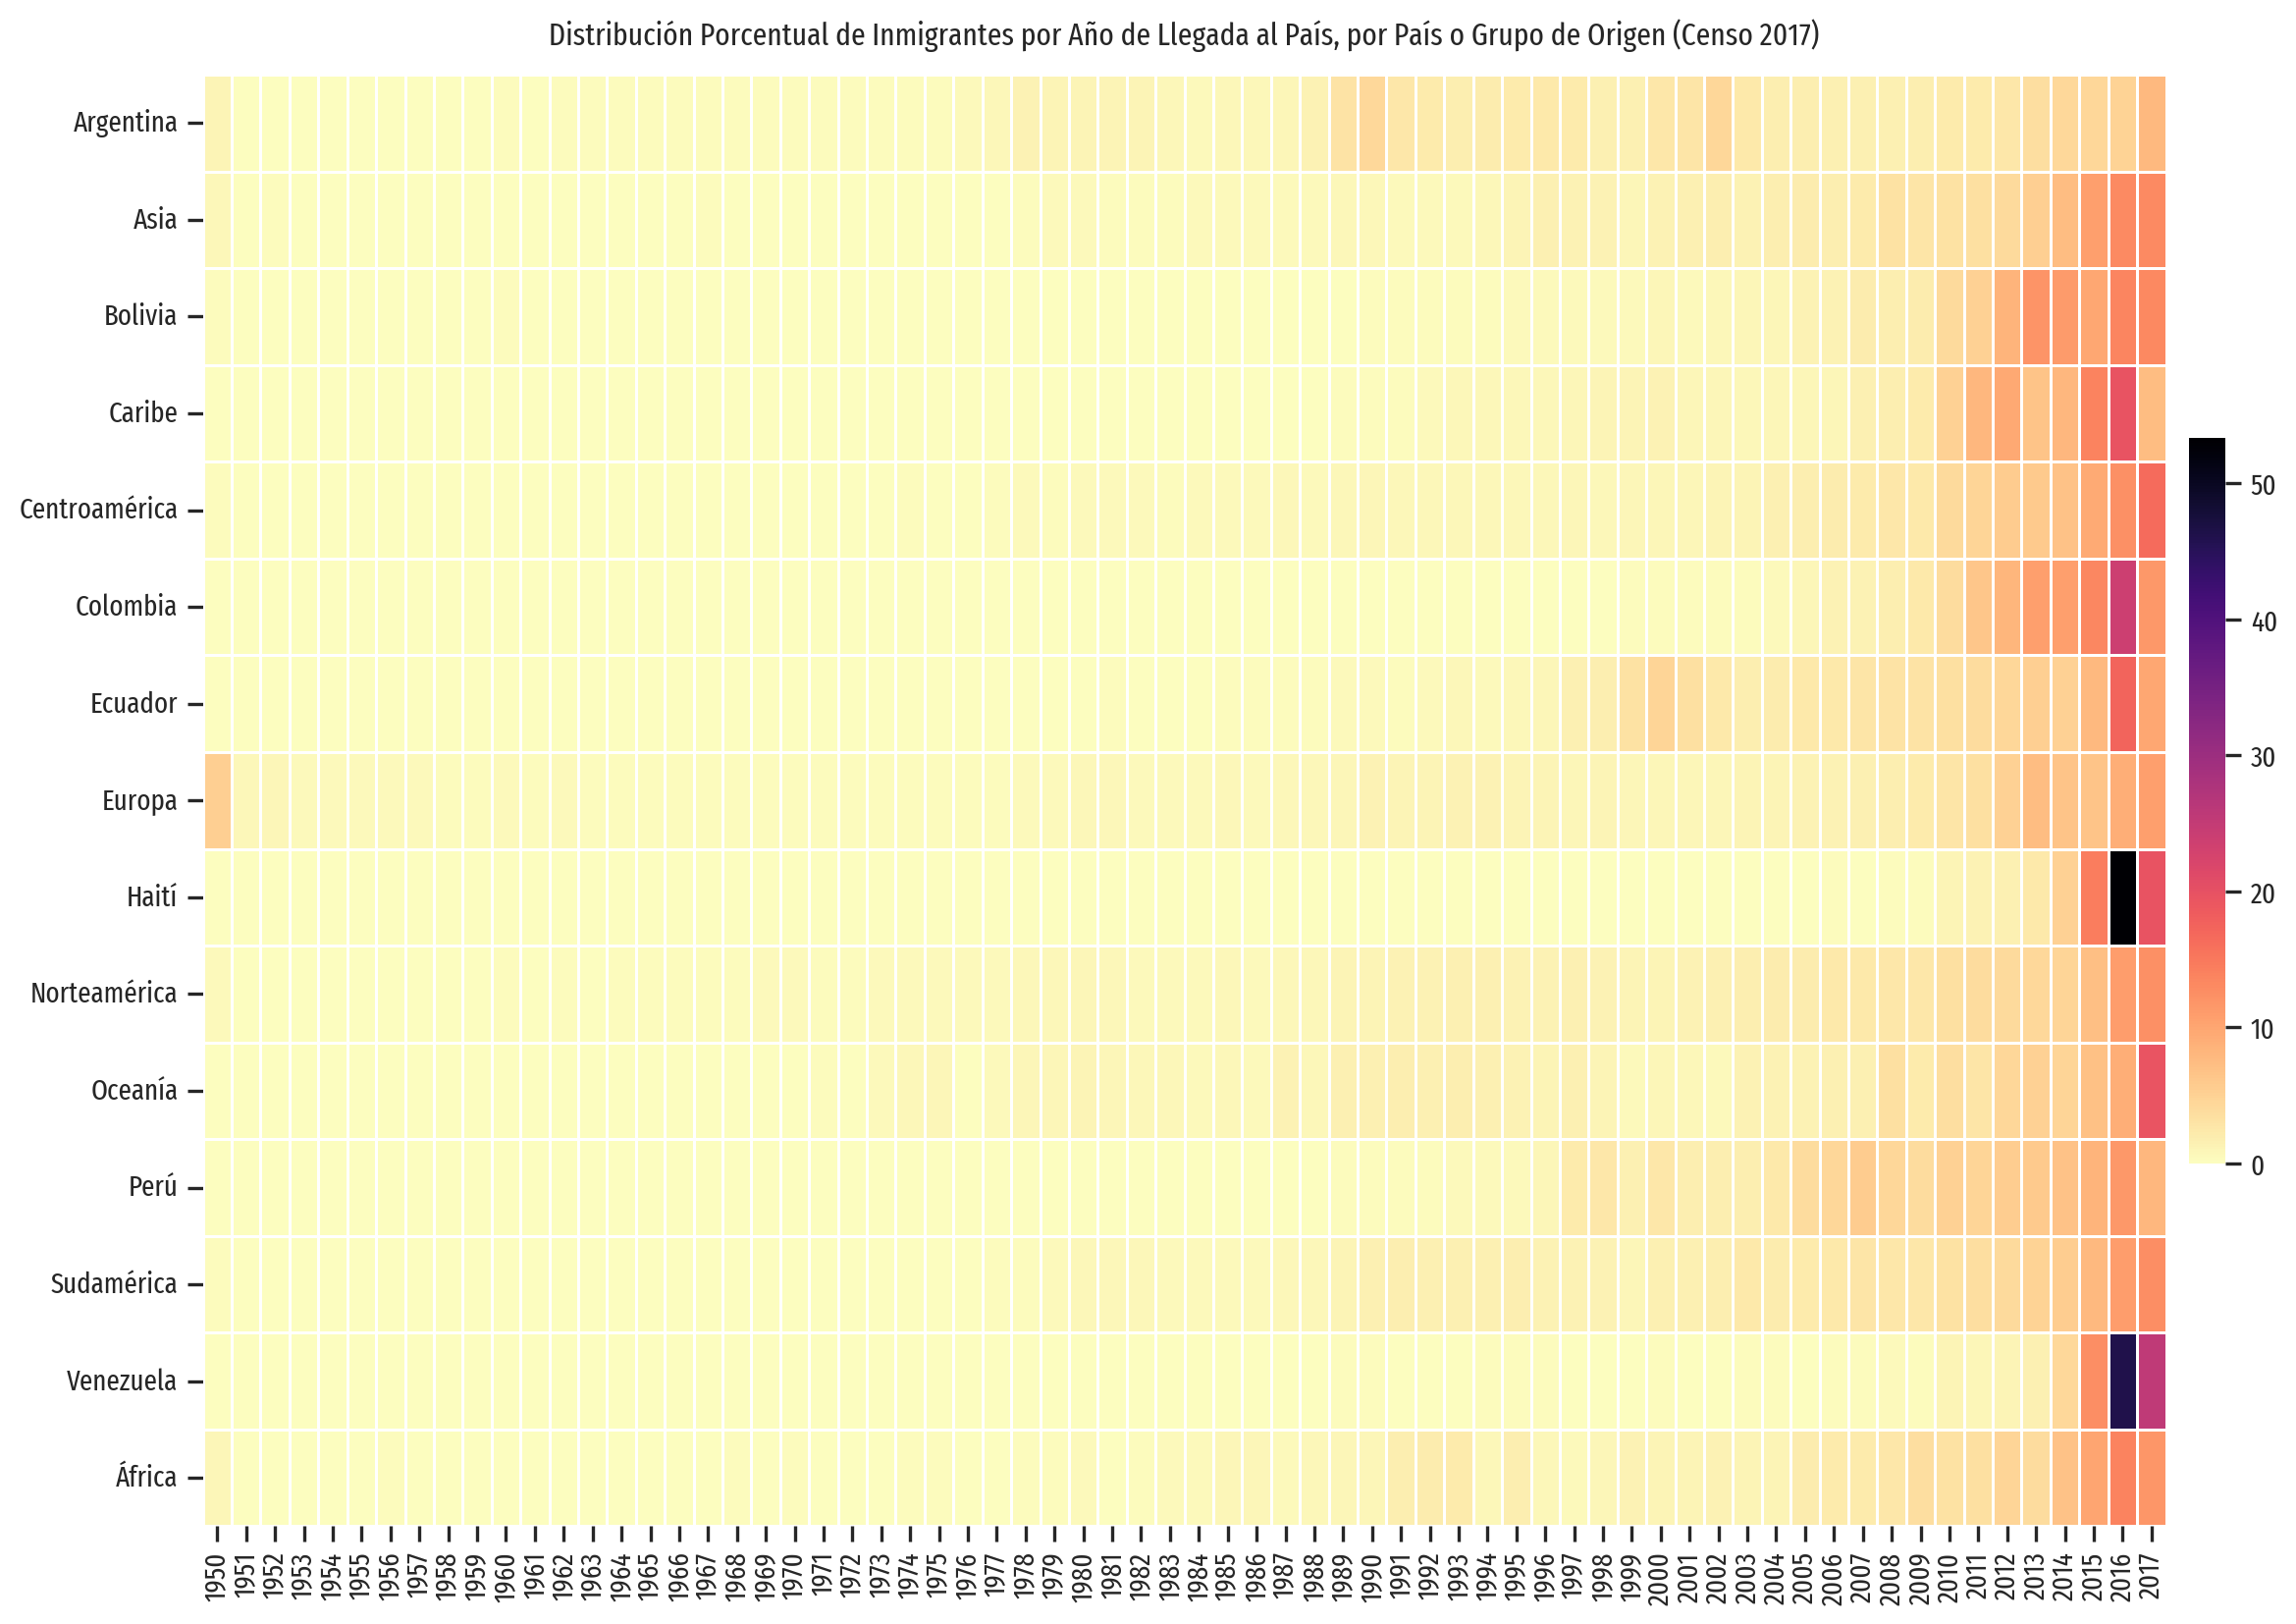

In [33]:
plt.figure(figsize=(16, 10))
sns.heatmap(year_series, cmap='magma_r', linewidth=1, cbar_kws=dict(shrink=0.5, pad=0.01), xticklabels=True)
plt.title('Distribución Porcentual de Inmigrantes por Año de Llegada al País, por País o Grupo de Origen (Censo 2017)', y=1.01)
plt.ylabel('')
plt.xlabel('')
plt.savefig('censo2017_figuras/migrant_matrix.png', dpi=150, bbox_inches='tight')

## ¿Existen diferencias en los destinos dentro de Chile donde residen, dependiendo del origen?

Haremos un procedimiento similar al de la pregunta anterior.

In [34]:
migrant_reg_counts = census.groupby(['P12PAIS_GRUPO', 'REGION']).size().compute()
migrant_reg_counts

P12PAIS_GRUPO  REGION
2              14            32
               15            10
5              14           184
               15           213
9              14            28
                          ...  
604            1          13724
862            1            619
997            1            158
998            1         278320
999            1           6176
Length: 270, dtype: int64

In [35]:
migrant_reg_counts=migrant_reg_counts.reset_index()
migrant_reg_counts

,P12PAIS_GRUPO,REGION,0
0,2,14,32
1,2,15,10
2,5,14,184
3,5,15,213
4,9,14,28
...,...,...,...
265,604,1,13724
266,862,1,619
267,997,1,158
268,998,1,278320


In [36]:
migrant_reg_counts.rename(columns={'P12PAIS_GRUPO':'CODIGO_PAIS', 0:'Nº_MIGRANTES'},inplace=True)
migrant_reg_counts

,CODIGO_PAIS,REGION,Nº_MIGRANTES
0,2,14,32
1,2,15,10
2,5,14,184
3,5,15,213
4,9,14,28
...,...,...,...
265,604,1,13724
266,862,1,619
267,997,1,158
268,998,1,278320


In [37]:
migrant_reg_counts=migrant_reg_counts[migrant_reg_counts['CODIGO_PAIS']<997]
migrant_reg_counts

,CODIGO_PAIS,REGION,Nº_MIGRANTES
0,2,14,32
1,2,15,10
2,5,14,184
3,5,15,213
4,9,14,28
...,...,...,...
262,170,1,3911
263,218,1,1389
264,332,1,127
265,604,1,13724


In [38]:
region_names = pd.read_csv('censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Regiones.csv', sep=';', index_col='REGION').reset_index()
region_names

,REGION,NOM_REGION
0,1,TARAPACÁ
1,2,ANTOFAGASTA
2,3,ATACAMA
3,4,COQUIMBO
4,5,VALPARAÍSO
5,6,LIBERTADOR BERNARDO O’HIGGINS
6,7,MAULE
7,8,BIOBÍO
8,9,ARAUCANÍA
9,10,LOS LAGOS


In [39]:
migrant_reg_counts.merge(region_names, on='REGION').merge(country_codes, on='CODIGO_PAIS')

,CODIGO_PAIS,REGION,Nº_MIGRANTES,NOM_REGION,CONTINENTE
0,2,14,32,LOS RÍOS,África
1,2,15,10,ARICA Y PARINACOTA,África
2,2,13,1068,METROPOLITANA,África
3,2,11,6,AYSÉN,África
4,2,12,49,MAGALLANES,África
...,...,...,...,...,...
220,862,5,3929,VALPARAÍSO,Venezuela (República Bolivariana de)
221,862,4,1138,COQUIMBO,Venezuela (República Bolivariana de)
222,862,3,281,ATACAMA,Venezuela (República Bolivariana de)
223,862,2,1029,ANTOFAGASTA,Venezuela (República Bolivariana de)


In [40]:
migrant_reg=migrant_reg_counts.merge(region_names, on='REGION').merge(country_codes, on='CODIGO_PAIS').pivot_table(index='CONTINENTE',columns='NOM_REGION', values='Nº_MIGRANTES')
migrant_reg

NOM_REGION,ANTOFAGASTA,ARAUCANÍA,ARICA Y PARINACOTA,ATACAMA,AYSÉN,BIOBÍO,COQUIMBO,LIBERTADOR BERNARDO O’HIGGINS,LOS LAGOS,LOS RÍOS,MAGALLANES,MAULE,METROPOLITANA,TARAPACÁ,VALPARAÍSO
CONTINENTE,,,,,,,,,,,,,,,
Argentina,2215,5976,369,527,1097,3399,1858,1859,4903,1615,2078,1693,35870,1123,9285
Asia,743,322,109,167,12,669,372,336,351,150,873,350,13716,2105,1379
Bolivia (Estado Plurinacional de),24578,169,8541,2877,22,455,1417,982,144,95,69,360,15089,20780,1925
Caribe,407,222,166,165,53,475,512,345,227,88,422,365,14974,474,886
Centroamérica,302,231,76,164,29,679,226,262,213,149,207,244,7321,153,1013
Colombia,19493,808,1076,2142,361,1993,3421,2118,1317,434,1247,1393,63614,3911,4673
Ecuador,1598,363,392,534,76,1150,821,1066,473,109,79,702,18032,1389,1828
Europa,1238,1411,365,405,233,2216,1571,925,1279,729,809,1260,31037,426,6708
Haití,16,298,6,61,45,581,763,2015,193,58,27,1604,55148,127,3625


Vamos a calcular el numero de migrantes por páis o continente de origen

In [41]:
region_totals = migrant_reg.sum(axis=1)
region_totals

CONTINENTE
Argentina                                73867
Asia                                     21654
Bolivia (Estado Plurinacional de)        77503
Caribe                                   19781
Centroamérica                            11269
Colombia                                108001
Ecuador                                  28612
Europa                                   50612
Haití                                    64567
Norteamérica                             16191
Oceanía                                   2250
Perú                                    192082
Sudamérica                               27040
Venezuela (República Bolivariana de)     85461
África                                    1722
dtype: int64

Ahora vamos a dividir cada fila en el total segun el país de origen

In [42]:
migrants_x_region=migrant_reg.div(region_totals, axis=0)*100
migrants_x_region

NOM_REGION,ANTOFAGASTA,ARAUCANÍA,ARICA Y PARINACOTA,ATACAMA,AYSÉN,BIOBÍO,COQUIMBO,LIBERTADOR BERNARDO O’HIGGINS,LOS LAGOS,LOS RÍOS,MAGALLANES,MAULE,METROPOLITANA,TARAPACÁ,VALPARAÍSO
CONTINENTE,,,,,,,,,,,,,,,
Argentina,2.998633,8.090216,0.499546,0.713444,1.485102,4.601514,2.515332,2.516685,6.637605,2.186362,2.813164,2.291957,48.560250,1.520300,12.569889
Asia,3.431237,1.487023,0.503371,0.771220,0.055417,3.089498,1.717927,1.551676,1.620948,0.692713,4.031588,1.616330,63.341646,9.721068,6.368338
Bolivia (Estado Plurinacional de),31.712321,0.218056,11.020219,3.712114,0.028386,0.587074,1.828316,1.267048,0.185799,0.122576,0.089029,0.464498,19.468924,26.811865,2.483775
Caribe,2.057530,1.122289,0.839189,0.834134,0.267934,2.401294,2.588342,1.744098,1.147566,0.444871,2.133360,1.845205,75.698903,2.396239,4.479046
Centroamérica,2.679918,2.049871,0.674417,1.455320,0.257343,6.025379,2.005502,2.324962,1.890141,1.322211,1.836898,2.165232,64.965835,1.357707,8.989263
Colombia,18.048907,0.748141,0.996287,1.983315,0.334256,1.845353,3.167563,1.961093,1.219433,0.401848,1.154619,1.289803,58.901306,3.621263,4.326812
Ecuador,5.585069,1.268698,1.370055,1.866350,0.265623,4.019293,2.869425,3.725709,1.653153,0.380959,0.276108,2.453516,63.022508,4.854606,6.388928
Europa,2.446060,2.787876,0.721173,0.800205,0.460365,4.378408,3.104007,1.827630,2.527069,1.440370,1.598435,2.489528,61.323402,0.841698,13.253774
Haití,0.024780,0.461536,0.009293,0.094476,0.069695,0.899840,1.181718,3.120789,0.298914,0.089829,0.041817,2.484241,85.412053,0.196695,5.614323


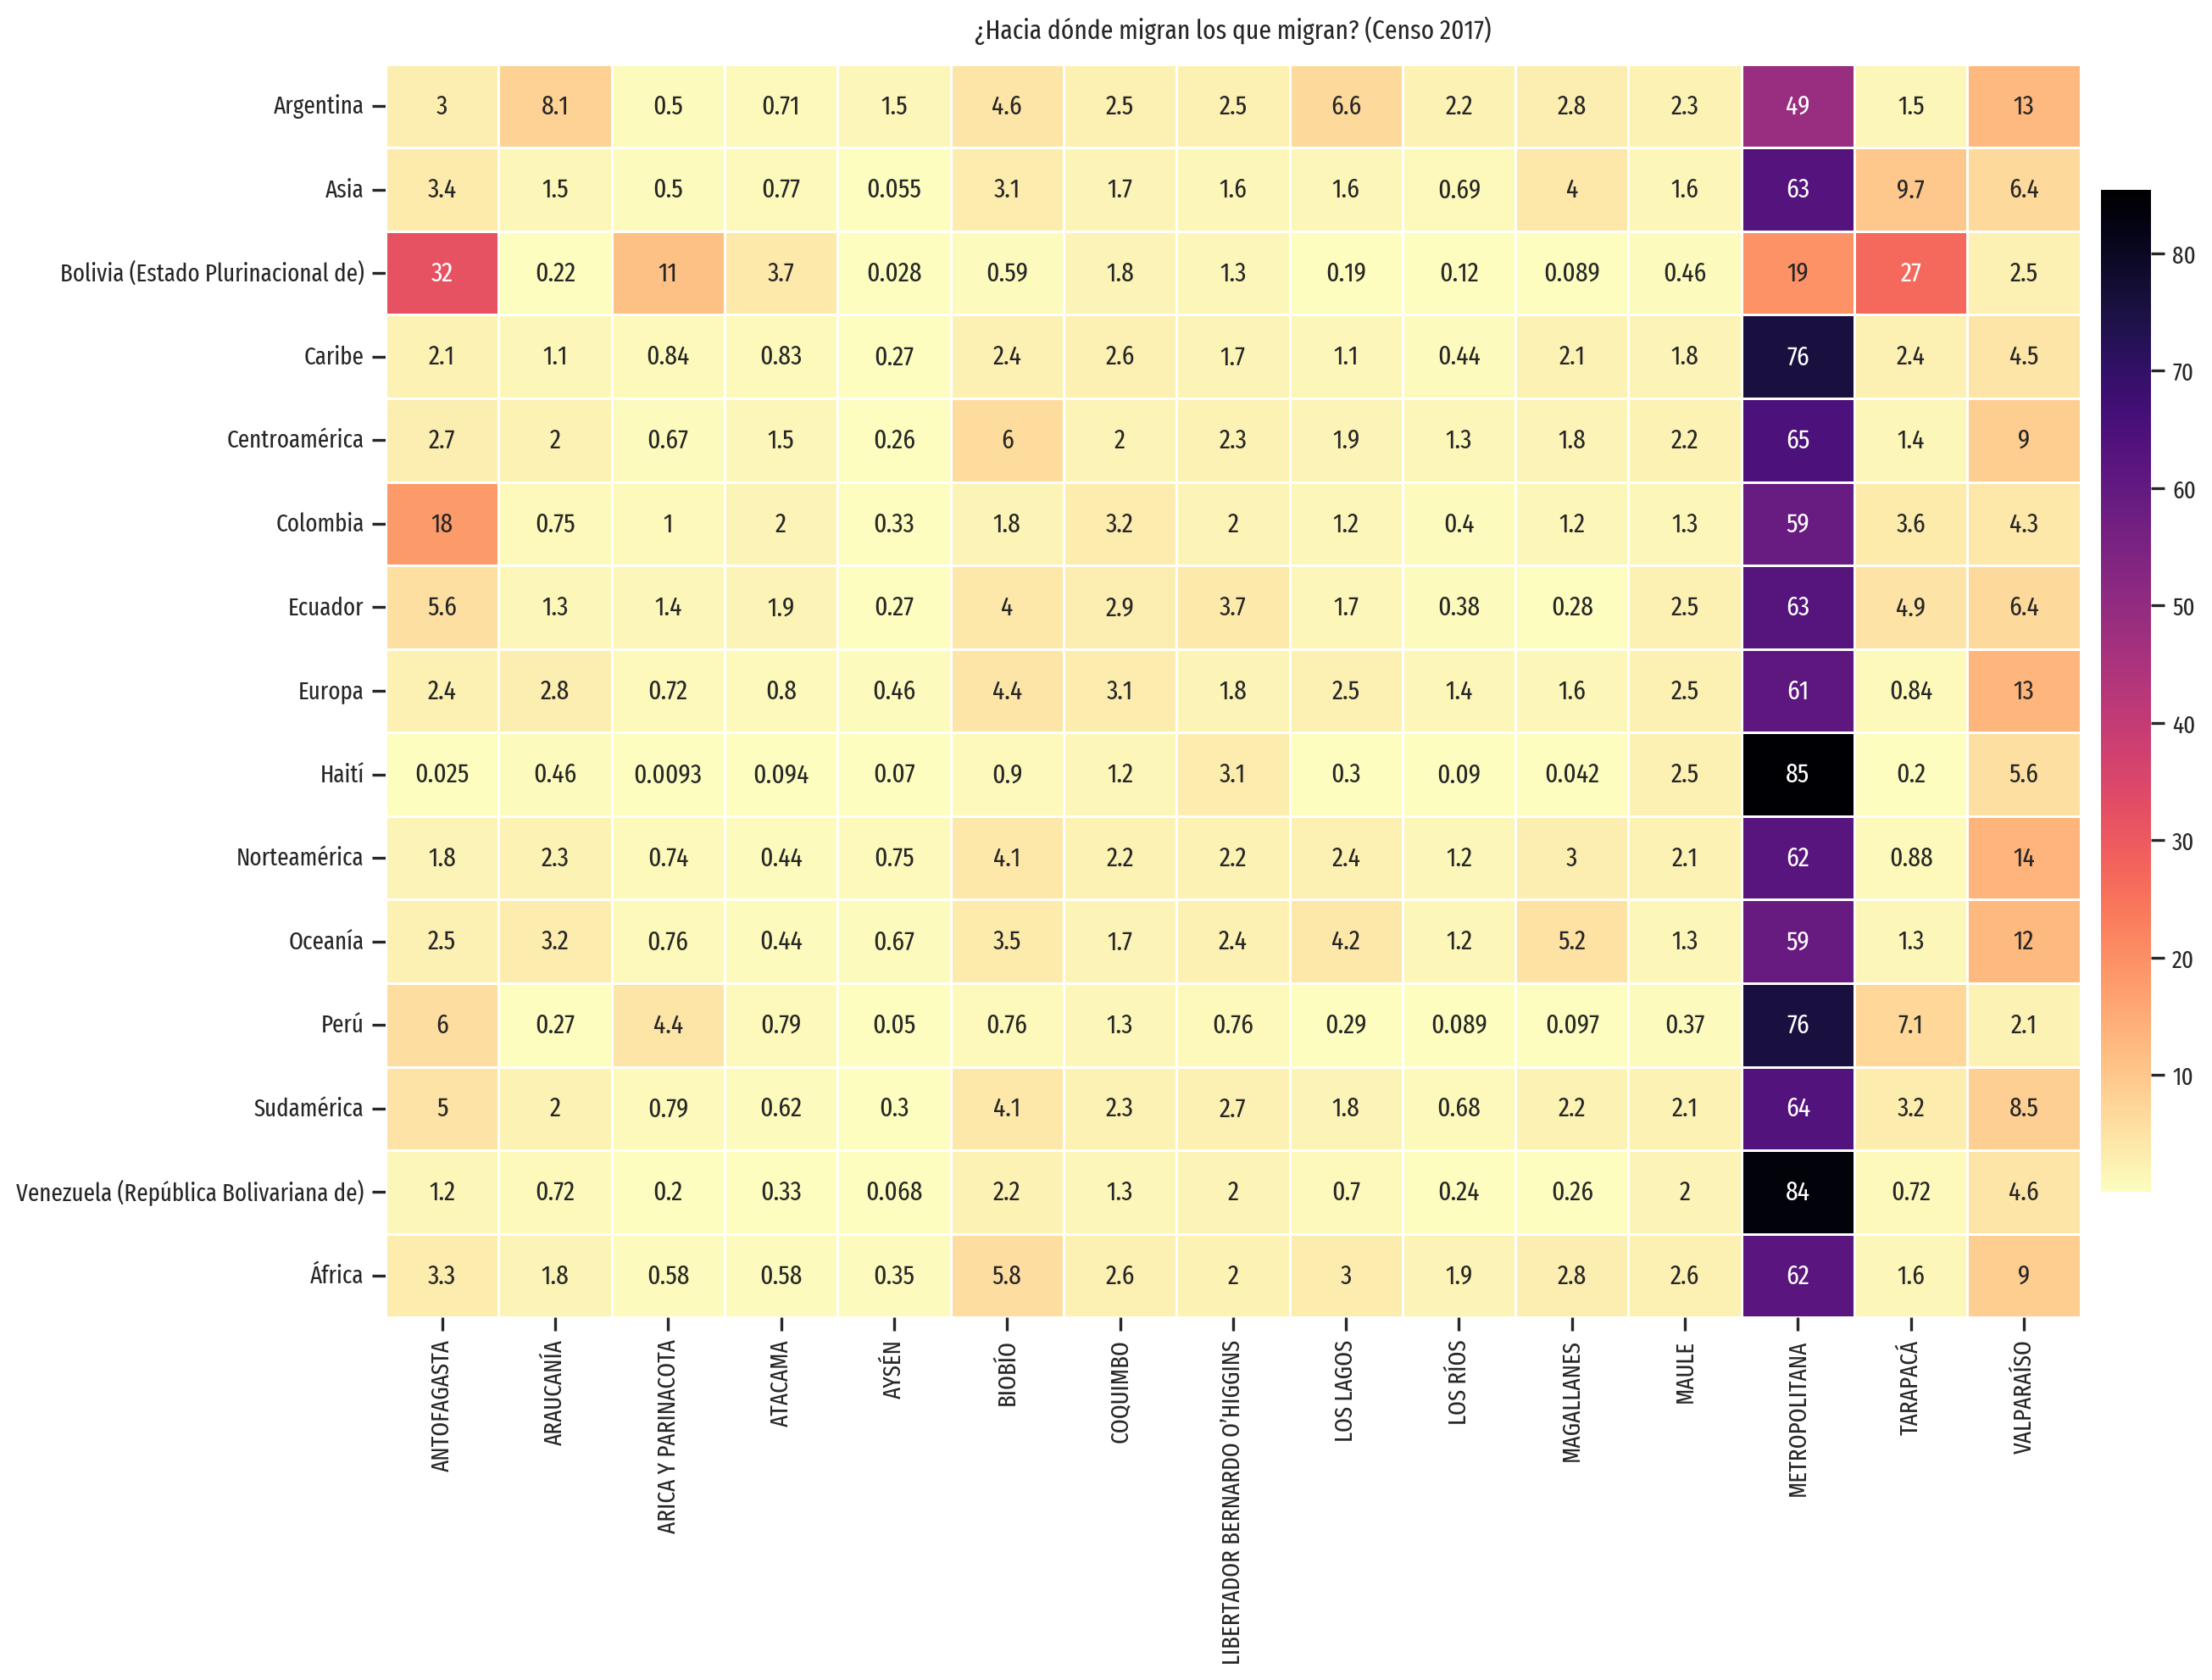

In [43]:
plt.figure(figsize=(16, 10))
sns.heatmap(migrants_x_region, cmap='magma_r', linewidth=1, cbar_kws=dict(shrink=0.8, pad=0.01), xticklabels=True, annot=True)
plt.title('¿Hacia dónde migran los que migran? (Censo 2017)', y=1.01)
plt.ylabel('')
plt.xlabel('')
plt.savefig('censo2017_figuras/migrant_matrix.png', dpi=150, bbox_inches='tight')

Esta vez si nos interesa ver el clustering, para poder identificar grupos de países o de regiones que tengan comportamiento similar.

Vamos a visualizar el dendograma sólo para el eje horizontal. Es decir, vamos a visualizar mostrando similitud en los países de origen.

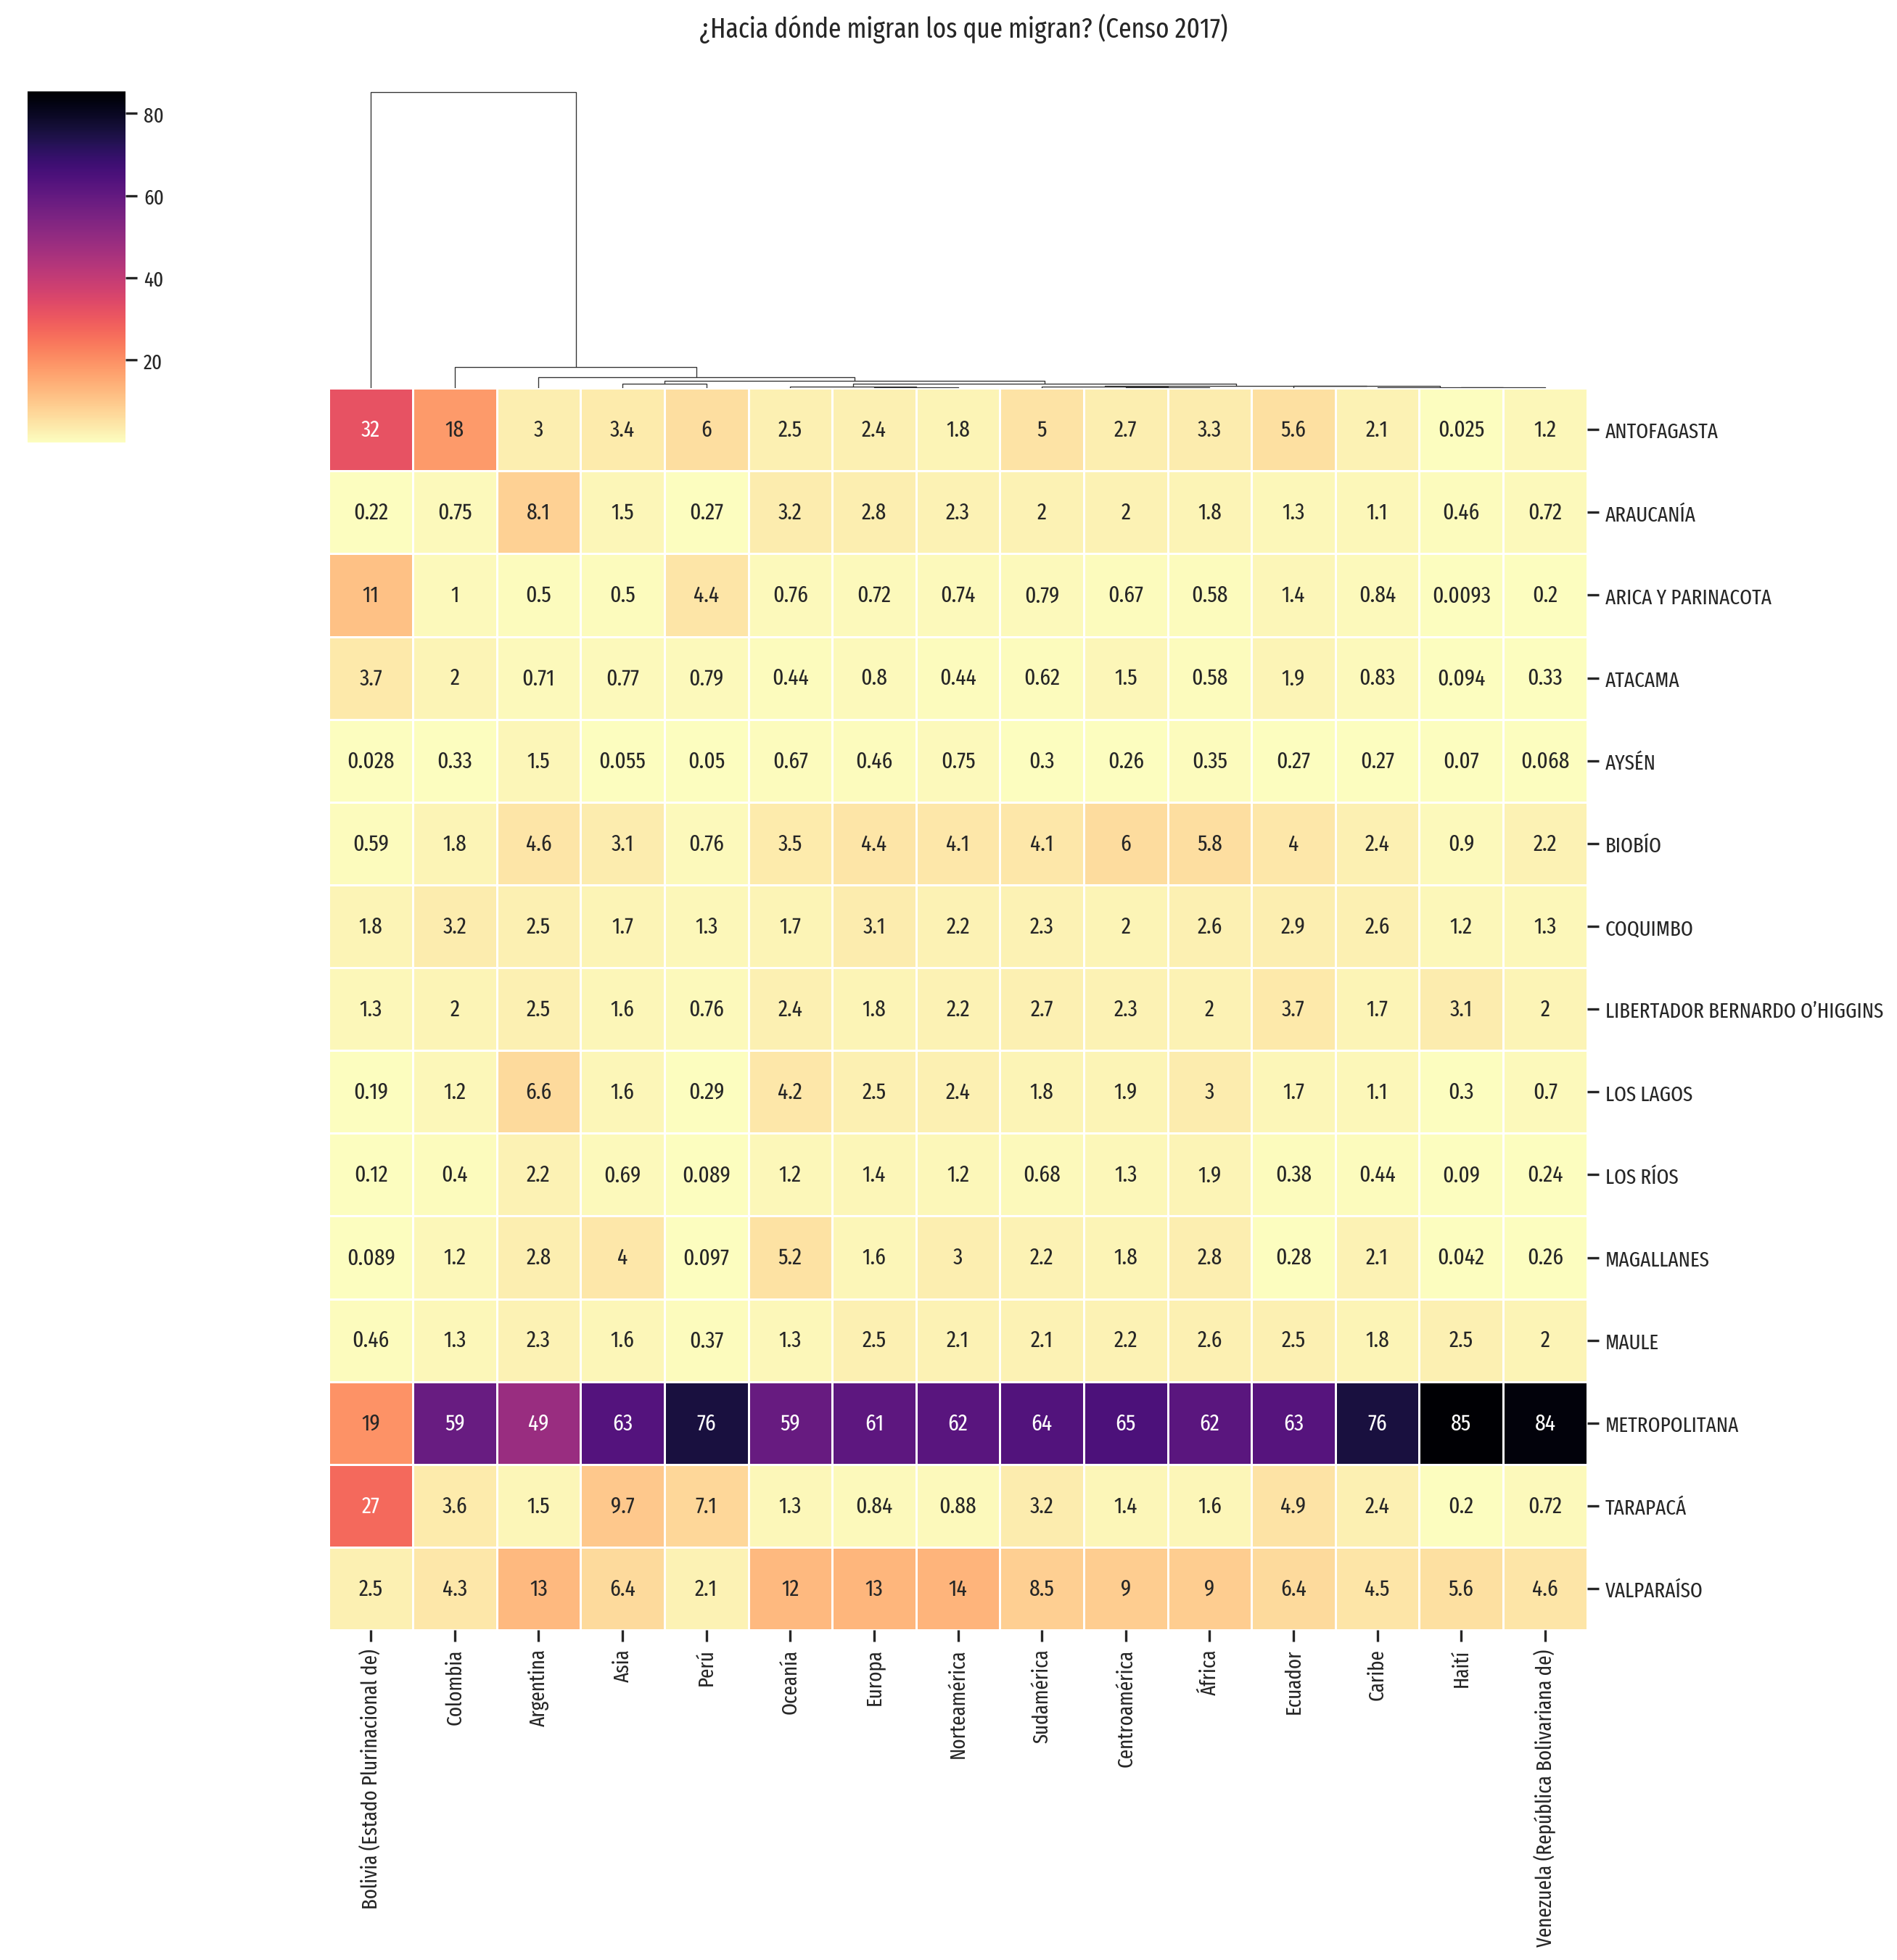

In [44]:
# Creando el mapa de calor con clusterización
g = sns.clustermap(migrants_x_region.T, cmap='magma_r', annot=True, figsize=(14,14), linewidth=1, metric='correlation', row_cluster=False)
# row_cluster=False desactiva el agrupamiento y el dendrograma para las filas (eje y)

# Remover las etiquetas de los ejes
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')

# Ajustando el título
plt.suptitle('¿Hacia dónde migran los que migran? (Censo 2017)', y=1.02)

# Guardando la figura
g.savefig('censo2017_figuras/migrants_per_region.png', dpi=150, bbox_inches='tight')


Y ahora sólo para el eje vertical. Organizamos las regiones de acuerdo a el origen de sus inmigranres.

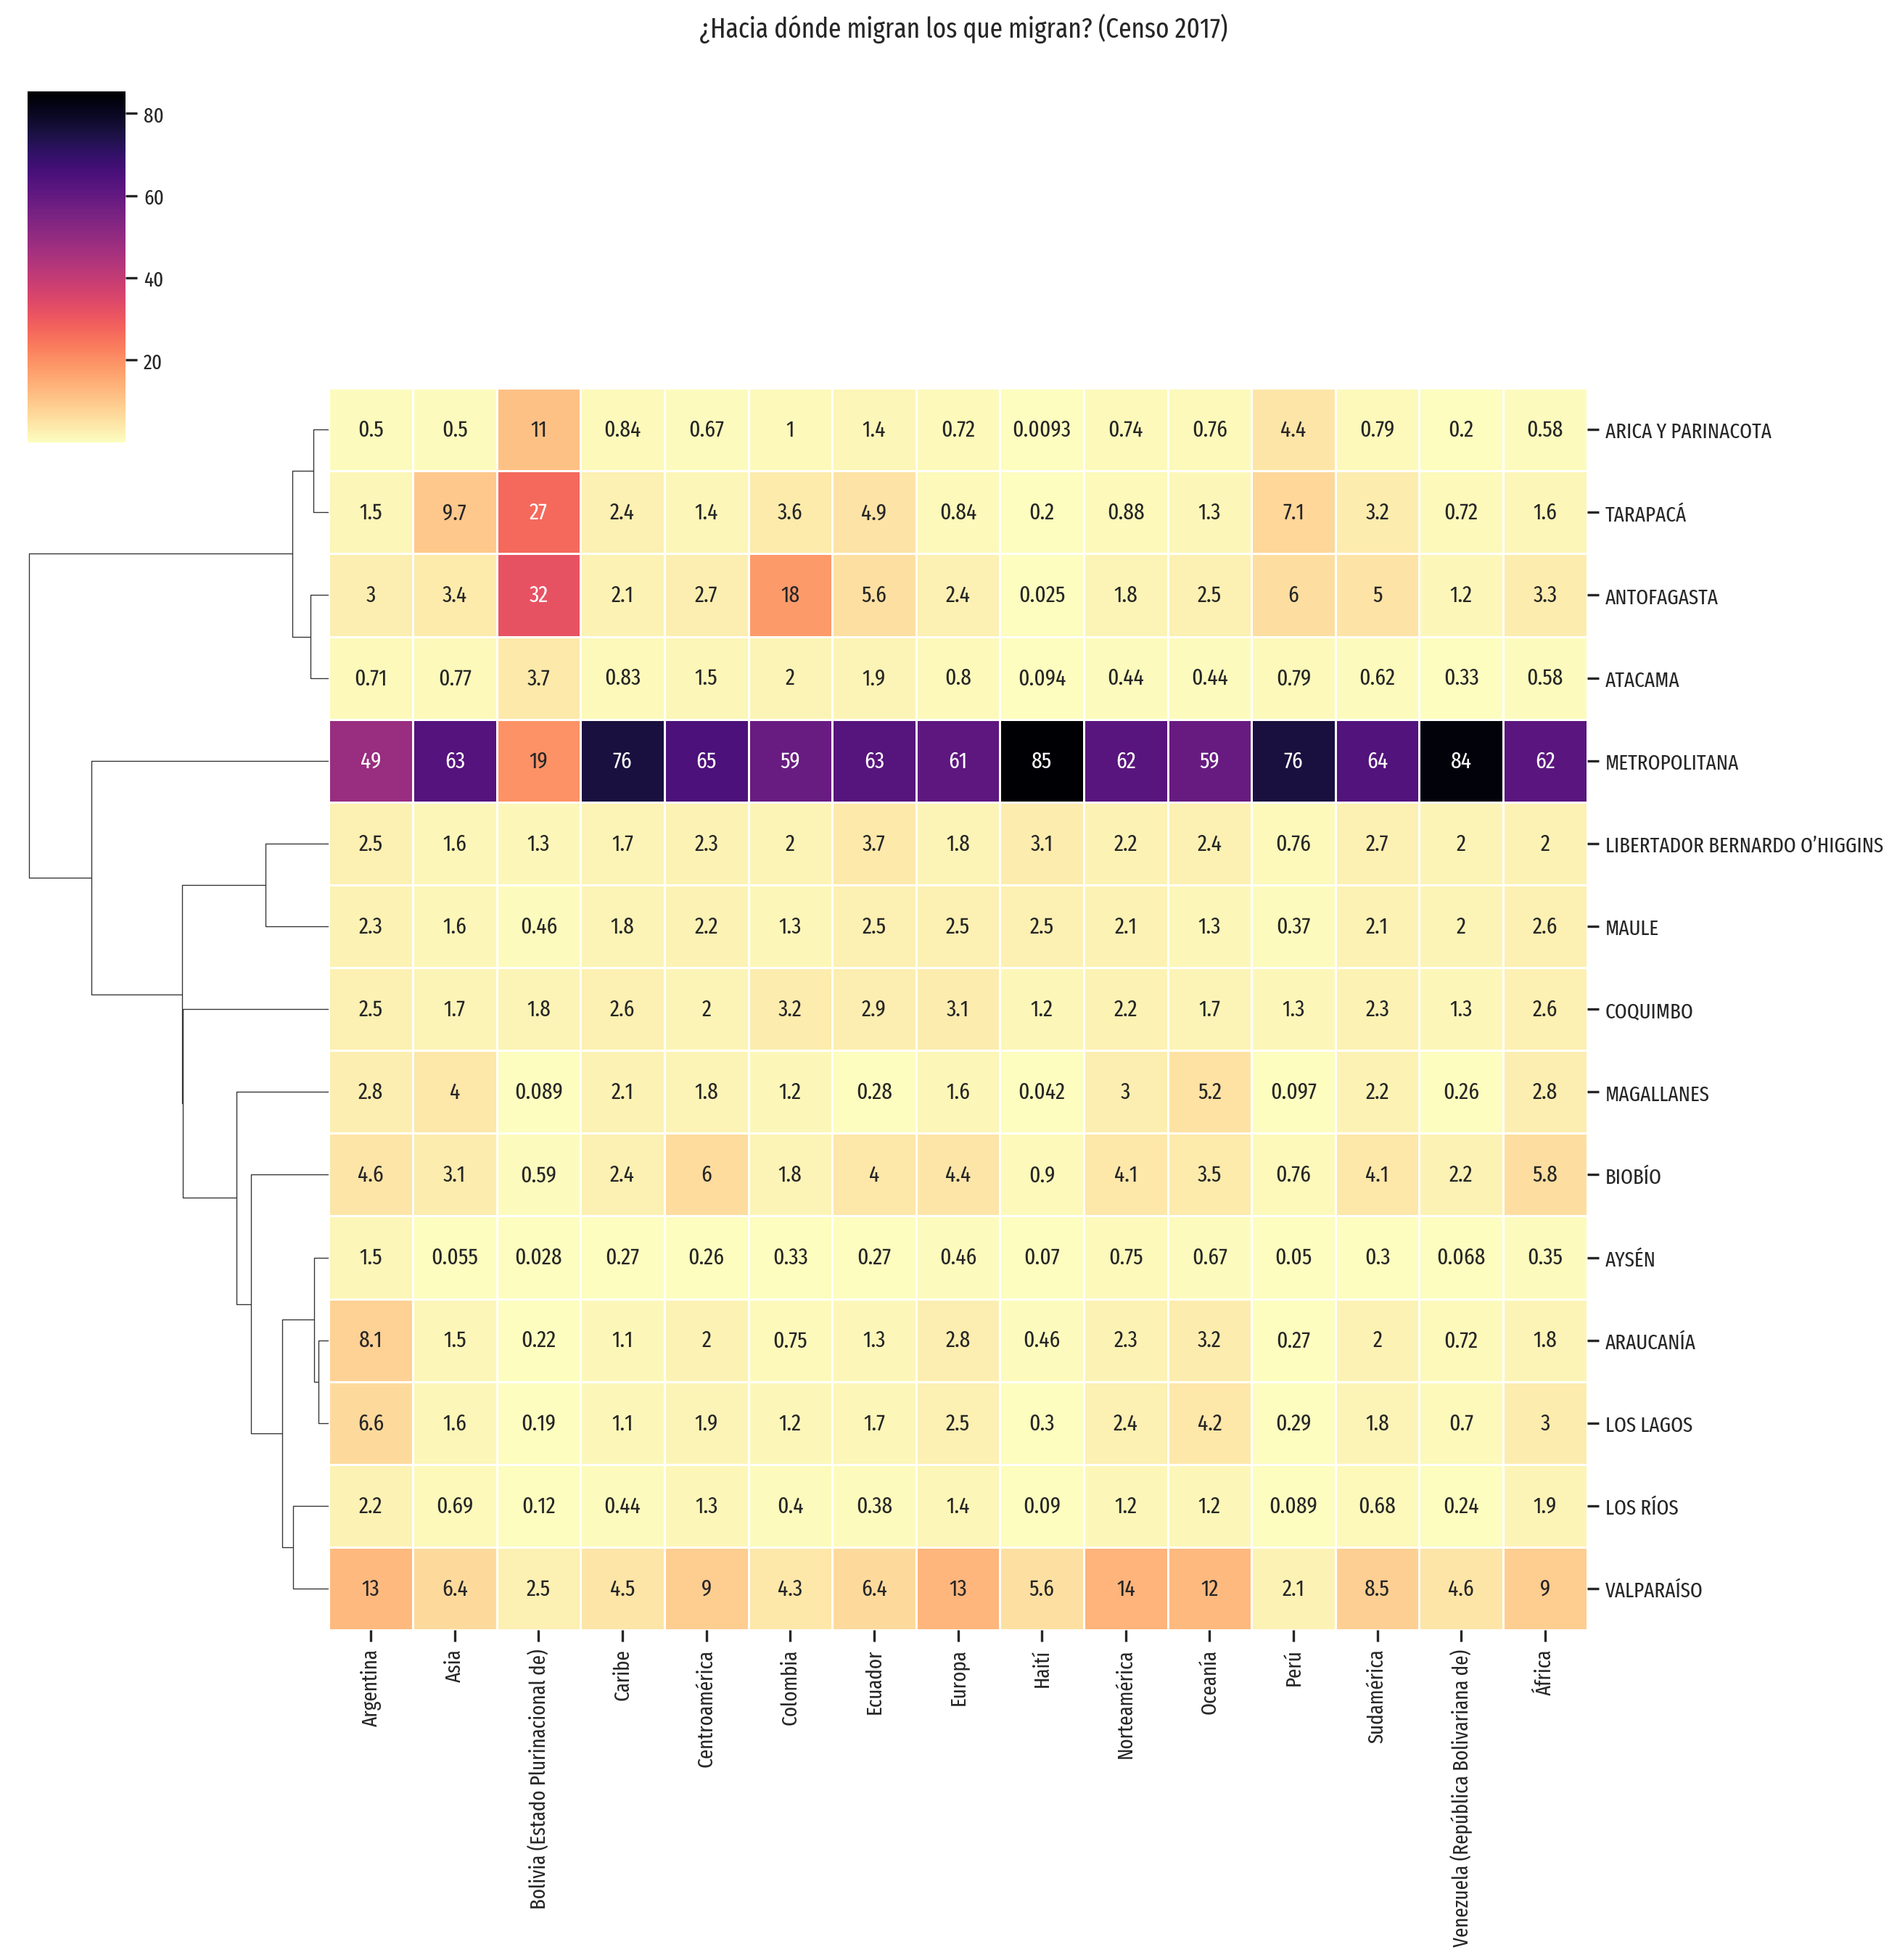

In [45]:
# Creando el mapa de calor con clusterización
g = sns.clustermap(migrants_x_region.T, cmap='magma_r', annot=True, figsize=(14,14), linewidth=1, metric='correlation', col_cluster=False)
# col_cluster=False desactiva el agrupamiento y el dendrograma para las columnas (eje x)

# Remover las etiquetas de los ejes
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')

# Ajustando el título
plt.suptitle('¿Hacia dónde migran los que migran? (Censo 2017)', y=1.02)

# Guardando la figura
g.savefig('censo2017_figuras/migrants_per_region.png', dpi=150, bbox_inches='tight')

# Fin

Con esto cerramos el ejemplo. Todavía hay cosas por hacer, por ejemplo, controlar por población en la última pregunta. Aún así, con esto ya tienes una buena base para hacer tus propias preguntas y realizar un análisis exploratorio.

No dudes en contactarme con sugerencias, correcciones y preguntas.